In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':'Arial'})
rc('text',usetex=True)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'

In [2]:
seq = {}
seq_file = './FinalSeqs/MALAT1_gene_all.fasta'
with open(seq_file) as file1:
    fl = 0
    for line in file1:
        if line.startswith('>') and fl == 0:
            l = []
            name = line.rstrip().lstrip('>')
            fl = 1
        elif line.startswith('>') and fl == 1:
            seq[name] = ''.join(l)
            l = []
            name = line.rstrip().lstrip('>')
        elif not line.startswith('>'):
            l.append(line.strip())
    seq[name] = ''.join(l)

In [1]:
tax_species = {}
poly = {}
latin = {}
neat1 = {}
length = {}
gaps = {}
with open('Metadata') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        if not line.startswith('#') and dat[4] == '1':
            dat = line.strip().split('\t')
            latin[dat[0]] = dat[1]
            tax_species[dat[0]] = dat[20].upper()
            neat1[dat[0]] = {}
            length[dat[0]] = int(dat[6])
            if dat[7]:
                poly[dat[0]] = [int(dat[7])]
            else:
                poly[dat[0]] = []
            if dat[11] not in ['0','Nan']:
                gaps[dat[0]] = [int(i) for i in dat[12].split(';')]


In [4]:
TE = json.load(open("./TE/MALAT1_non_overlapping_TE.json","r"))

In [5]:
colors = {}
for i in range(50,101):
    if i < 60:
        colors[i] = '#C2C2C2'
    elif i >= 60 and i < 70:
        colors[i] = '#EED1A8'
    elif i >= 70 and i < 80:
        colors[i] = '#D8D3E5'
    elif i >= 80 and i < 90:
        colors[i] = '#CBE0BA'
    else:
        colors[i] = '#FAD7D5'

In [6]:
GQ = {}
with open('./Archetypes/GQuadPredicted_MALAT1') as file1:
    for line in file1:
        if not line.startswith('sequenceName') and not line.startswith('#'):
            dat = line.strip().split(',')
            name = dat[0].replace('"','')
            if name not in GQ:
                GQ[name] = []
            for i in range(int(dat[1]),int(dat[2])):
                GQ[name].append(i)

In [7]:
ssr = {}
with open('./SSR_search/MALAT1_SSR.misa') as file1:
    for line in file1:
        if not line.startswith('ID'):
            dat = line.strip().split('\t')
            if dat[0] in neat1:
                if dat[0] not in ssr:
                    ssr[dat[0]] = [0 for i in range(length[dat[0]])]
                for i in range(int(dat[-2]),int(dat[-1])):
                    ssr[dat[0]][i] = -1

In [15]:
blast = {}
c = 1
with open('./BLAST_all_vs_all/MALAT1_all_vs_all.txt') as file1:
    for line in file1:
        dat = line.strip().split('\t')
        if int(dat[2]) > 100:
            if dat[0] not in blast:
                blast[dat[0]] = {}
            if dat[1] not in blast[dat[0]]:
                blast[dat[0]][dat[1]] = {}
            a = [int(dat[4]),int(dat[6])]
            b = [int(dat[5]),int(dat[7])]
            blast[dat[0]][dat[1]][c] = [a,b,int(round(float(dat[3]),0))]
            c += 1

In [9]:
d = json.load(open("./BLAST_all_vs_all/MALAT1_ANI.json","r"))

In [10]:
Archetypes = ['GCF_015852505.1_mTacAcu1.pri', 'GCF_016433145.1_AgileGrace', 'GCA_016432865.2_AdamAnt_v2',
         'GCF_000313985.2_ASM31398v2', 'GCA_000152225.2_Pcap_2.0', 'GCF_014898055.1_MPIMG_talOcc4',
          'GCA_029834395.2_SorCin_2.1', 'Human_MALAT1', 'GCA_013371645.1_OryCun3.0',
         'GCF_014633375.1_OchPri4.0', 'GCF_020740685.1_mJacJac1.mat.Y.cur', 'GCA_023101885.1_KIZ_TCIN_v1.0',
         'Mouse_MALAT1','GCF_019054845.1_ASM1905484v1', 'GCA_004027875.1_AplRuf_v1_BIUU']

In [11]:
colormap = {'DNA':'#efba36','SINE':'#f96861','LINE':'#80b364','Other':'#cfc5ea',
           '70':'#EED1A8','80':'#D8D3E5','90':'#CBE0BA','100':'#FAD7D5',
           'g4':'#d470a0','polya':'#686868','ssr':'royalblue','kmer':'#d470a0','Other2':'#8c5792'}

In [12]:
def print_alignment(genomes, filename, figsize, text_start, xlim,fsizeticks,fsizeleg,fontsize,namelength,GQflag,ANI):
    global blast
    global GQ, TE
    global poly
    global ssr
    global length
    global colormap
    
    xstart = 0
    plt.figure(figsize=figsize)
    fig,ax = plt.subplots()
    for idx in range(1,len(genomes)):
        #Plot similarity between 2 orthologs
        genome1 = genomes[idx - 1 ]
        genome2 = genomes[idx]
        if genome1 in blast and genome2 in blast[genome1]:
            for item in blast[genome1][genome2]:
                start = blast[genome1][genome2][item][0]
                end = blast[genome1][genome2][item][1]
                polygon = mpatches.Polygon([(start[1],idx+1), (end[1],idx+1),(end[0],idx),(start[0],idx)],
                                         facecolor=colors[blast[genome1][genome2][item][2]],
                                          edgecolor='black',linewidth=0.2)
                ax.add_patch(polygon)

        plt.plot([idx for i in range(length[genome1])],'s',color='dimgray',markersize=0.2)
        ## PLOT ELEMENTS FOR GENOME 1
        #Plot G-quadruplexes locations
        if GQflag:
            g = [idx if i in GQ[genome1] else 0 for i in range(length[genome1])]
            plt.plot(g, '|',markersize=5,color=colormap['g4'])

        #Plot locations of SSR
        if genome1 in ssr:
            sp = [idx if ssr[genome1][i] == -1 else 0 for i in range(length[genome1])]
            plt.plot(sp, '|',markersize=7,color=colormap['ssr'])
        
        #Plot locations of sequence gaps
        if genome1 in gaps:
            g = [idx if i in gaps[genome1] else 0 for i in range(length[genome1])]
            plt.plot(g, '|',markersize=3,color='black')
        #Plot TEs in colours in accordance to their classification
        if genome1 in TE:
            for element in TE[genome1]:
                if 'DNA' in element:
                    color=colormap['DNA']
                elif 'SINE' in element:
                    color=colormap['SINE']
                elif 'LINE' in element:
                    color = colormap['LINE']
                else:
                    color=colormap['Other']
                a = [idx if i in range(TE[genome1][element][1],TE[genome1][element][2]) else 0 for i in range(length[genome1])]
                plt.plot(a, 's',markersize=4,color=color)
        # Add species names
        if namelength == 'short':
            genname1 = latin[genome1].split('\ ')[0][0] + '. ' + latin[genome1].split(' ')[1]
            genname2 = latin[genome2].split('\ ')[0][0] + '. ' + latin[genome2].split(' ')[1]
        elif namelength == 'long':
            genname1 = '\ '.join(latin[genome1].split(' ')[:2])
            genname2 = '\ '.join(latin[genome2].split(' ')[:2])

        if ANI:
            plt.text(-3000, idx+0.4, str(round(d[genome1][genome2],2)) + " \%",fontsize=fontsize)
        else:
            plt.text(text_start, idx, r"$\mathit{" + genname1 + "}$",fontsize=fontsize, fontstyle='italic')
            plt.text(text_start, idx+1, r"$\mathit{" + genname2 + "}$",fontsize=fontsize, fontstyle='italic')
        idx += 1
        
    ## PLOT ELEMENTS FOR GENOME 2
    
    plt.plot([idx for i in range(length[genome2])],'s',color='dimgray',markersize=0.2)
    
    #Plot location of SSR
    sp = [idx if ssr[genome2][i] == -1 else 0 for i in range(length[genome2])]
    plt.plot(sp, '|',markersize=7,color=colormap['ssr'])
    
    #Plot locations of assembly gaps
    if genome2 in gaps:
        g = [idx if i in gaps[genome2] else 0 for i in range(length[genome2])]
        plt.plot(g, '|',markersize=3,color='black')
        
    #Plot locations of G-quadruplexes
    if GQflag:
        g = [idx if i in GQ[genome2] else 0 for i in range(length[genome2])]
        plt.plot(g, '|',markersize=5,color=colormap['g4'])
    #Plot TEs in colours in accordance to their classification
    if genome2 in TE:
        for element in TE[genome2]:
            if 'DNA' in element:
                color=colormap['DNA']
            elif 'SINE' in element:
                color=colormap['SINE']
            elif 'LINE' in element:
                color = colormap['LINE']
            else:
                color=colormap['Other']
            a = [idx if i in range(TE[genome2][element][1],TE[genome2][element][2]) else 0 for i in range(length[genome2])]
            plt.plot(a, 's',markersize=4,color=color)
    #Set general figure parameters
    plt.xlim([0,xlim])
    plt.ylim([0.5,len(genomes) + 10])
    plt.yticks([])
    plt.xticks(fontsize=fsizeticks)

    #Legend
    patch_70 = mpatches.Patch(color=colormap['70'], label='60-70')
    patch_80 = mpatches.Patch(color=colormap['80'], label='70-80')
    patch_90 = mpatches.Patch(color=colormap['90'], label='80-90')
    patch_100 = mpatches.Patch(color=colormap['100'], label='$>$ 90')
    patch_LINE = mpatches.Patch(color=colormap['LINE'], label='LINE')
    patch_SINE = mpatches.Patch(color=colormap['SINE'], label='SINE')
    patch_DNA = mpatches.Patch(color=colormap['DNA'], label='DNA')
    #patch_Other = mpatches.Patch(color=colormap['Other2'], label='ERV')
    patch_Other = mpatches.Patch(color=colormap['Other'], label='Other')
    patch_gap = mlines.Line2D([],[],color='black',marker='|',markersize=6,label='Assembly gap')
    patch_te = mlines.Line2D([],[],color=colormap['ssr'],marker='|',markersize=6,label='SSRs')
    patch_polya = mlines.Line2D([],[],color=colormap['polya'],marker='D',markersize=3,label='NEAT1Short 3\'-end')
    plt.legend(handles=[patch_70,patch_80,patch_90,patch_100,patch_LINE,patch_SINE,patch_DNA,patch_Other,patch_te,
                       patch_polya, patch_gap], title_fontsize=6,
               fontsize = fsizeleg,title='Homology %',frameon=False)

    # Save the figure
    plt.box(False)
    plt.tight_layout()
    plt.savefig('./FiguresPublication/MALAT1_' + filename + '.png',dpi=300)

<Figure size 864x288 with 0 Axes>

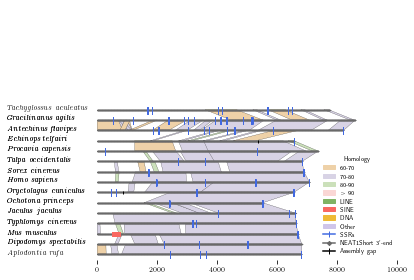

In [16]:

genomes = Archetypes[::-1]
xlim = 10000
text_start = -3000
filename = 'Archetypes'
figsize=(12, 4)
fsizeticks = 7
fsizeleg = 6
fontsize=7
namelength = 'long'
print_alignment(genomes, filename, figsize, text_start, xlim,fsizeticks,fsizeleg, fontsize, namelength,'','')

<Figure size 864x288 with 0 Axes>

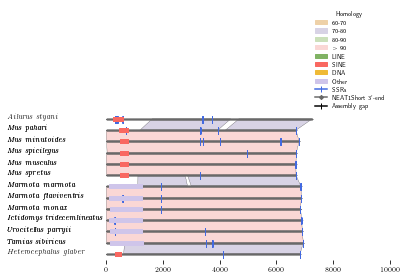

In [14]:
# Alignment of MALAT1 orthologs with TEs
genomes = ['GCF_000247695.1_HetGla_female_1.0', 'GCA_025594165.1_ASM2559416v1', 'GCF_003426925.1_ASM342692v1', 
       'GCF_016881025.1_HiC_Itri_2', 'GCF_021218885.1_Marmota_monax_Labrador192_V1.0', 'GCF_003676075.2_GSC_YBM_2.0',
       'GCF_001458135.1_marMar2.1', 'GCA_921997135.2_SPRET_EiJ_v3','Mouse_MALAT1', 'GCA_003336285.2_MUSP714_v2', 
       'GCA_902729485.2_Mus_minutoides_I2396_v1', 'GCF_900095145.1_PAHARI_EIJ_v1.1', 'GCA_002007465.1_ASM200746v1']
xlim = 10000
text_start = -3500
filename = 'with_TEs'
figsize=(12, 4)
fsizeticks = 7
fsizeleg = 6
fontsize=7
namelength = 'long'
print_alignment(genomes, filename, figsize, text_start, xlim,fsizeticks,fsizeleg, fontsize, namelength,'','')